# nestpy Tutorial

Sophia Andaloro (sja5@rice.edu)
<br>
Feb. 2, 2021
<br>

### Outline
1. Yields (vectorized)
2. Quanta generation 
3. Signal generation
4. Energy resolution/acceptance
5. Sensitivity (ER/NR leakage)

### First, some imports (and boring python itializing)

In [1]:
import nestpy

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [2]:
%run setup_notebook.py

nestpy version: v1.5.4
NEST version: v2.3.9


### Initializing our Detector 

We mentioned that the "Virtual Detector" is the heart of NEST's macro-micro-physics calculations (recombination fluctuations all the way to S2 area corrections, depend on your detector file.) 
<br>
Thankfully, NEST has a couple of these built in for you to start with. 
I'm using a LUX (public) file but you can select or make your own.
<br>
If you want to construct your own detector: copy-paste the file and rename it, change your settings, ensure all defined detector names are fixed, and then add it to the bindings.cpp and recompile nestpy, and you are good to go. 

In [3]:
detector = nestpy.LUX_Run03()

Let's check some of the parameters. 
<br>
Note that if there's a negative value for the S2 threshold, it means that we're using the bottom array for S2 values (cS2_b, which is common in some analyses.) Else, we're using the full observed S2 signal.
You can change any of these values around but if you choose things that would give you unphysical values, NEST will likely yell at you. 

In [4]:
pp.pprint(dir(detector))

[   'FitEF',
    'FitS1',
    'FitS2',
    'FitTBA',
    'Initialization',
    'OptTrans',
    'SinglePEWaveForm',
    '__class__',
    '__delattr__',
    '__dir__',
    '__doc__',
    '__eq__',
    '__format__',
    '__ge__',
    '__getattribute__',
    '__gt__',
    '__hash__',
    '__init__',
    '__init_subclass__',
    '__le__',
    '__lt__',
    '__module__',
    '__ne__',
    '__new__',
    '__reduce__',
    '__reduce_ex__',
    '__repr__',
    '__setattr__',
    '__sizeof__',
    '__str__',
    '__subclasshook__',
    'get_E_gas',
    'get_P_dphe',
    'get_PosResBase',
    'get_PosResExp',
    'get_T_Kelvin',
    'get_TopDrift',
    'get_anode',
    'get_cathode',
    'get_coinLevel',
    'get_coinWind',
    'get_dtCntr',
    'get_dt_max',
    'get_dt_min',
    'get_eLife_us',
    'get_g1',
    'get_g1_gas',
    'get_gate',
    'get_inGas',
    'get_numPMTs',
    'get_p_bar',
    'get_radius',
    'get_s2Fano',
    'get_s2_thr',
    'get_sPEeff',
    'get_sPEres',
    'get_sPE

In [5]:
E_gas = detector.get_E_gas()
print('Gas gap field for detector is: %.2f kV/cm'%(E_gas))

Gas gap field for detector is: 6.25 kV/cm


We can also initialize our `NESTcalc` object, which talks to NEST.cpp, in essence. 
This means any calculations done by `NESTcalc` will rely on our detector parameters in our header file.

In [6]:
nc = nestpy.NESTcalc(detector)

# nuisance and free parameters in NEST. 
# For some reason binding to these is tricky 
# So I am simply calling them here so my code 
# Does not break (yes, that's not elegant, I Know)
nuisance = nestpy.default_nr_yields_params()
free = nestpy.default_nrer_widths_params()

I also explicitly get some constants that are helpful for later so I'm not always calling the `nestpy` and `detector` modules every time.

In [7]:
g1 = detector.get_g1()
g2_params = nc.CalculateG2(False)
g2 = g2_params[3]

## 1. Yields
Yields are the heart of NEST, and its shining strength.
Every subsequent calculation depends on our yields, including our quanta. 

You can calculate yields for all interaction types in NEST, and it's been recently vectorized
in nestpy so that you can compute these yields for thousands of different energy/field configurations quickly.

In [8]:
version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')

In [9]:
def yields_curve(interaction=nestpy.nr, fields=[81.], 
                 energy_min=1e-1, energy_max=1e2):
    """
    Get yields from nestpy from energy min to energy max 
    """
    energies = np.logspace(np.log10(energy_min), np.log10(energy_max), 1000,)
    energies = np.reshape(energies, (1000,1))
    energies = np.broadcast_to(energies, (len(energies), len(fields)))

    kwargs = {'interaction': interaction,
              'energy': energies, 
              'drift_field': fields}

    ly = nestpy.PhotonYield(**kwargs)/energies
    qy = nestpy.ElectronYield(**kwargs)/energies

    return (energies, ly, qy)

In [10]:
%%time 
energies, ly, qy = yields_curve(interaction=nestpy.nr, fields=[100., 200.], 
                               energy_min=0.1, energy_max=200.)

CPU times: user 28.5 ms, sys: 788 µs, total: 29.3 ms
Wall time: 28.4 ms


In [11]:
def yields_plot(fields=[100.],
                interaction=nestpy.nr,
                energy_min=0.1, energy_max=200.,
                interaction_title='Nuclear Recoil',
                yields_type='LY',
                savefig=None, 
                **kwargs):
    '''
    Makes a plot of all the different yields at various energies and field values.
    '''
    
    energies, ly, qy = yields_curve(interaction=interaction, 
                                    fields=fields, 
                                    energy_min=0.1, energy_max=200.)
    
    plt.figure(1, figsize=(9,6))
    subplot1 = plt.subplot(1,1,1)
    
    if yields_type.lower()=='ly':
        y, ylabel = ly, r'Photon yield [n$_\gamma$/keV]'

    elif yields_type.lower()=='qy':
        y, ylabel = qy, r'Electron yield [n$_e$/keV]'    
        
    for f, field in enumerate(fields):
        subplot1.plot(energies[:,f], y[:,f], 
                      label='%.0f V/cm'%(field))
        
    subplot1.legend(loc='best', fontsize='large', ncol=1)
    plt.xscale('log')
    
    title=yields_type + ' for ' + interaction_title
    subplot1.set_title(title, fontdict = font_medium)
    subplot1.set_xlabel('Interaction Energy [keV]', fontdict=font_small)
    subplot1.set_ylabel(ylabel, fontdict=font_small)
    
    subplot1.margins(0)
    plt.show()
    if savefig is not None:
        plt.savefig(yield_type+'_'+str(savefig)+'.png')

We can change around these parameters to get the various 'benchmark plots' we desire.

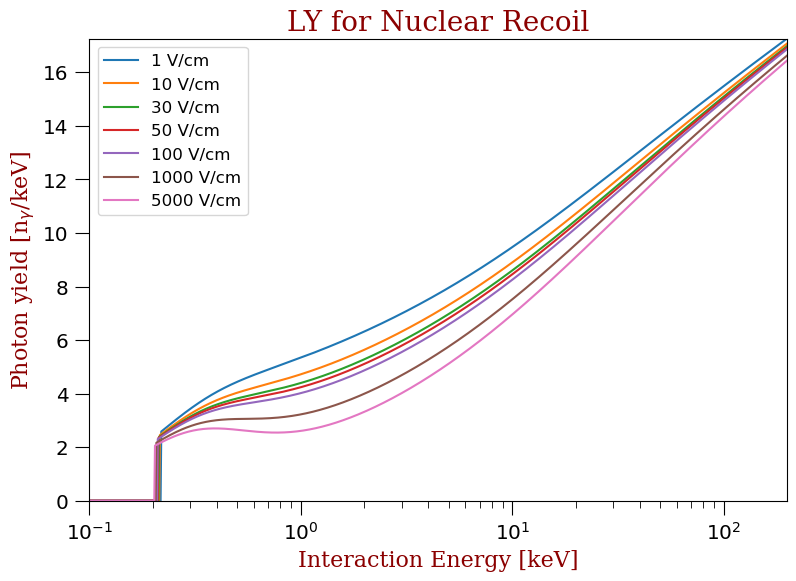

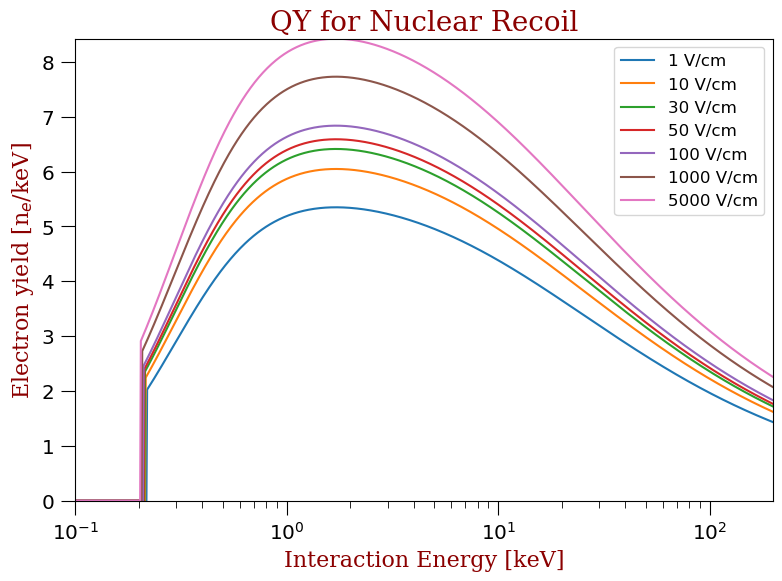

In [12]:
fields = [1., 10., 30., 50., 100., 1000., 5000.]
yields_plot(fields, interaction=nestpy.nr,
            energy_min=0.1, energy_max=200.,
            interaction_title='Nuclear Recoil',
            yields_type='LY',
            savefig=None, 
           )
yields_plot(fields, interaction=nestpy.nr,
            energy_min=0.1, energy_max=200.,
            interaction_title='Nuclear Recoil',
            yields_type='QY',
            savefig=None, 
           )

## 2. Quanta Generation

Quanta generation is not quite as hands-off since it depends more on the detector attributes. 

We have to specify some values like A, Z and density (which determine for instance our W_value.) 

**First we'll define some functions for generating quanta and establish some constants**

In [13]:
A = 131.293 # avg atomic mass of Xe
Z = 54. # Atomic number of Xe 

density = nc.GetDensity( T=detector.get_T_Kelvin(), P=detector.get_p_bar(), inGas=False )
print( "Using detector's LXe density, %.3f g/cc" % density)
#if no arguments provided, it uses the Detector file's defaults


Using detector's LXe density, 2.889 g/cc


In [14]:
# Getting quanta
# NOTE: you want to use the SAME call to get your 
# photons and electrons (i.e. make quanta the same object for both)
# so that anticorrelation is preserved, as we expect.
@np.vectorize
def GetQuanta(interaction=nestpy.NR, 
              energy=100., # energy in keV of the recoil itself
              drift_field=81.): # V/cm
    
    #What's first done in nestpy is getting the yields 
    #Based on the arguments below; most important, energy, density, field.
    #To see the spectrum of these, see nest.ucdavis.edu/benchmarkplots 
    y = nc.GetYields(interaction,
     energy,
     density,
     drift_field,
     A,
     Z,
    ) 
    # Then we call nestcalc class' function, GetQuanta 
    quanta = nc.GetQuanta(y, density)
    photons, electrons = quanta.photons, quanta.electrons

    return photons, electrons

Let's switch it up and model some beta-ERs now (monoenergetic to start):

In [15]:
N = 50000
E_mono = 10 # keVee
E_er = np.ones(N)*E_mono
# E_er = 10**(np.random.uniform(low=0, high=3, size=N))
field = 81.

photons, electrons = GetQuanta(nestpy.beta, E_er, field)
kwargs = {'energy': E_mono, 'drift_field': field}
nest_ly = nestpy.PhotonYield(interaction=nestpy.beta, **kwargs)
nest_qy = nestpy.ElectronYield(interaction=nestpy.beta, **kwargs)

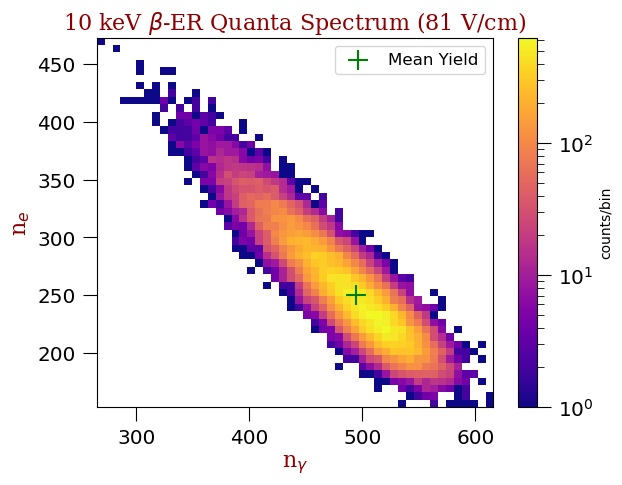

In [16]:
plt.hist2d(photons, electrons,
          bins=50, 
          cmin=1, 
          norm=LogNorm(),
          cmap = cm.plasma,
          )
plt.colorbar(label='counts/bin')
plt.scatter(nest_ly, nest_qy,
            s=200, marker='+', c='green', 
           label='Mean Yield')
plt.xlabel(r'n$_\gamma$', fontdict=font_small)
plt.ylabel(r'n$_e$', fontdict=font_small)
plt.title(r'%.0f keV $\beta$-ER Quanta Spectrum (%.0f V/cm)'%(E_mono, field), fontdict=font_small)
plt.legend(fontsize='large')
plt.show()

Of course we can get fancy and make bands of this rather than just doing monoenergetic. 
We'll do that later on for some more detailed calculations.

## 3. Signal Generation 

Let's model S1s and S2s similarly for a monoenergetic source to start. 

### Defining S1/S2 generation functions & helpers

In [19]:
@np.vectorize
def get_drift_v(field, temp=177.15):
    dv = nc.SetDriftVelocity(temp, # K temp
                            density,
                            field)
    return dv

#Calculate the work function ev/quanta 
# This is done in nest but I found it simpler
# To just transcribe it here since there is no 
# Dependence except density. 
def calc_Wq(density=density):
    MolarMass = 131.293
    NEST_AVO = 6.0221409e23
    ATOM_NUM = 54.
    eDensity = ( density / MolarMass ) * NEST_AVO * ATOM_NUM
    Wq_eV = 20.7 - 1.01e-23 * eDensity
    
    return Wq_eV

def calc_Wq(density=density):
    #Using new W bindings
    W = nc.WorkFunction( rho=density )
    return W.Wq_eV


In [22]:
# these mean we don't compute photon times. 
# it's a bit more crude but over 100x faster. 
# So always do for a first-order approximation. 
S1mode = nestpy.S1CalculationMode.Hybrid   #Options are Full, Parametric, Hybrid, or Waveform
S2mode = nestpy.S2CalculationMode.Full     #Options are Full, or Waveform
output_timing = 0
wftime = [0, 0, 0]
wfamp = [0., 0., 0.]

lifetime = detector.get_eLife_us() # us
FreeParam = nestpy.default_nrer_widths_params()
FudgeFactor = [1,1]# FreeParam[4:6]
Wq_eV = calc_Wq(density=density)

In [23]:
# This function gets both S1 and S2 for reliable anticorrelation.
@np.vectorize
def GetS1_S2(interaction=nestpy.NR, 
              energy=100., # energy in keV of the recoil itself
              drift_field=81.): # V/cm

    y = nc.GetYields(interaction,
     energy,
     density,
     drift_field,
     A,
     Z,
    ) 

    q = nc.GetQuanta(y, density)

    driftv = get_drift_v(drift_field)
    dv_mid = get_drift_v(drift_field) #assume uniform field 
    maxposz = 560 # max z position in mm  
    #We'll randomly select some positions to get realistic xyz smearing. 
    random_r = np.sqrt(np.random.uniform(0, 200.**2)) 
    random_theta = np.random.uniform(0, 2*np.pi)
    truthposx, truthposy, truthposz = random_r*np.cos(random_theta), random_r*np.sin(random_theta),np.random.uniform(60., 540.)
    smearposx, smearposy, smearposz = truthposx, truthposy, truthposz # random positions?
    
    dt = np.abs((truthposz - maxposz)/driftv)
    S1 = nc.GetS1(q, truthposx, truthposy, truthposz,
                        smearposx, smearposy, smearposz,
                        driftv, dv_mid, # drift velocities (assume homogeneous drift field)
                        interaction, 1, #int type, event # 
                        drift_field, energy, #dfield, energy
                        S1mode, output_timing,
                        wftime,
                        wfamp)

    S2 = nc.GetS2(q.electrons, 
                    truthposx, truthposy, truthposz,
                    smearposx, smearposy, smearposz,
                    dt, driftv, 1, #evt num
                    drift_field, S2mode, output_timing, # dv dvmid 
                    wftime, wfamp, 
                    g2_params)
    
    # S1[7] is the spike area, corrected for xyz position, and dividing out dpe effect.
    # S2[7] here is cs2_b, again correcting for DPE, xyz position, DAQ smearing
    cs1 = S1[7] 
    cs2 = S2[7]
    return cs1, cs2

In [24]:
s1, s2 = GetS1_S2(nestpy.beta, E_er, field)

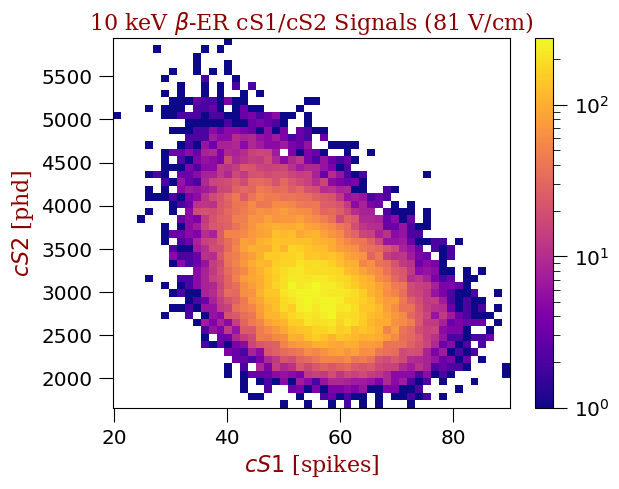

In [25]:
plt.hist2d(s1,s2, 
           bins=50, 
          cmin=1, 
          norm=LogNorm(),
          cmap = cm.plasma,           
          )
plt.colorbar()
plt.xlabel(r'$cS1$ [spikes]', fontdict=font_small)
plt.ylabel(r'$cS2$ [phd]', fontdict=font_small)
plt.title(r'%.0f keV $\beta$-ER cS1/cS2 Signals (%.0f V/cm)'%(E_mono, field), fontdict=font_small)
plt.show()

## 4. Energy Reconstruction

This is where, IMHO, you will want to build/integrate into your own fancier code. 
NEST has some E_reco fits available but yours will be faster. There is virtually no benefit to using NEST (i.e. globally fitting to physics) in fitting Gaussians, to my knowledge.

In [26]:
def threshold_pass(s1, s2, E, threshold=0):
    above_threshold = np.logical_and(s1>=threshold, s2>=threshold)
    s2 = s2[above_threshold]
    s1 = s1[above_threshold]
    E = E[above_threshold]
    return s1, s2, E

In [27]:
def get_E_reco(s1, s2, E_er):
    s1, s2, E_true = threshold_pass(s1, s2, E_er) # remove areas <=0 (not detected)
    E_reco = (s1/g1 + s2/g2) * 1e-3 * Wq_eV # in keV 
    return E_reco

In [28]:
E_reco = get_E_reco(s1, s2, E_er)

In [29]:
def fit_1d_gaussian(data):
    mean, sigma = norm.fit(data)
    return mean, sigma

In [30]:
E_mean, sigma_E = fit_1d_gaussian(E_reco)

In [31]:
x = np.linspace(np.min(E_reco), np.max(E_reco), 100)
p = norm.pdf(x, loc=E_mean, scale=sigma_E)

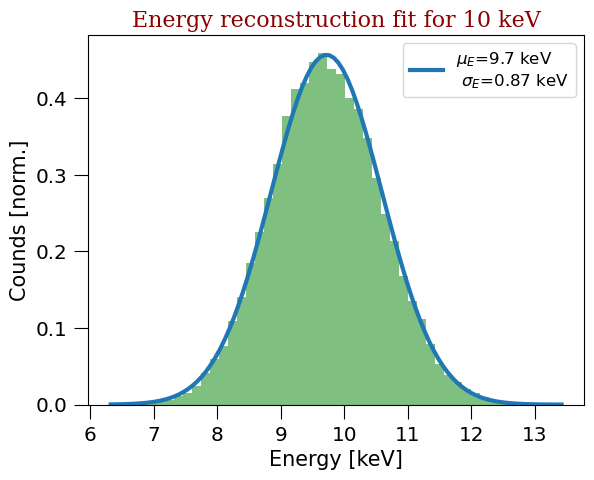

In [32]:
plt.hist(E_reco, 
        bins=50, 
        density=True,
        color='green', alpha=0.5)
plt.plot(x, p, linewidth=3, label='$\mu_E$=%.1f keV \n $\sigma_E$=%.2f keV'%(E_mean, sigma_E))
plt.legend(fontsize=12)
plt.xlabel('Energy [keV]', fontsize=15)
plt.ylabel('Counds [norm.]', fontsize=15)
plt.title('Energy reconstruction fit for %.0f keV'%(E_mono), fontdict=font_small)
plt.show()

## 4b. Detector Efficiency (Acceptance)

We'll now look at a range of energy values and calculate the acceptance (efficiency) at detecting events of a specific energy with our virtual detector. 

In [33]:
N = 5000
E_er_space = np.linspace(0.1, 10, 20)
E_er = np.kron(E_er_space, np.ones((1,N))).T
fields=[20., 100., 1000.]

In [34]:
efficiencies = np.empty((E_er_space.shape[0], len(fields)))

for f, field in enumerate(fields):
    print('Calculating for field: %.0f V/cm'%(field))
    s1, s2 = GetS1_S2(nestpy.beta, E_er, field)
    
    s1, s2, E_true = threshold_pass(s1, s2, E_er) # remove areas <=0 (not detected)
    
    for i, E_bin in enumerate(E_er_space):
        index = np.where(E_true==E_bin) #get particular energy value
        efficiency = index[0].shape[0]/N
        
        efficiencies[i, f] = efficiency 

Calculating for field: 20 V/cm
Calculating for field: 100 V/cm
Calculating for field: 1000 V/cm


Let's fit some sigmoids to the efficiency

In [35]:
def objective(x, a, b):
    return 1/(1+np.exp(-1*(a*(x-b))))

In [36]:
def fit_data(x, f):
    popt, _ = curve_fit(objective, E_er_space, efficiencies[:,f])
    a, b= popt
    fit = objective(x, a, b)
    return fit

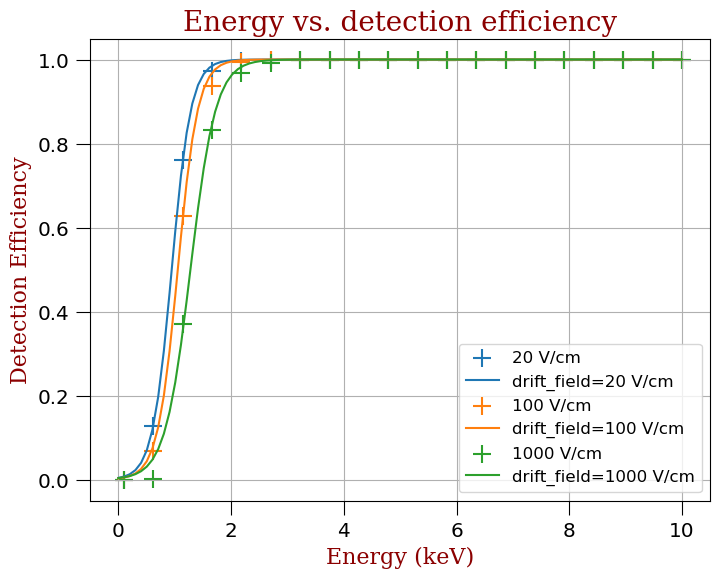

In [37]:
plt.figure(figsize=(8,6))
x = np.linspace(0, 10, 100)

for f, field in enumerate(fields):
    plt.scatter(E_er_space, efficiencies[:, f], 
                label='%.0f V/cm'%(field), 
               marker='+', s=150)
    plt.plot(x, fit_data(x,f), 
             label='drift_field=%.0f V/cm'%(field),)
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)', fontdict=font_small)
plt.ylabel('Detection Efficiency', fontdict=font_small)
plt.title('Energy vs. detection efficiency', fontdict=font_medium)
plt.grid(True)
plt.show()

## 5. Sensitivity (ER/NR Leakage)

Finally, let's look at a quick-calculation of the ER/NR leakage fraction. 

In [38]:
def cut(s1, s2, 
        s1_acc=1, s2_acc=100, 
        s1_max=100):
    mask = np.logical_and(s1>s1_acc, s2>s2_acc)
    mask &= s1<=s1_max
    return s1[mask], s2[mask]

In [39]:
N = 1000000
E_er_max = 20. 
E_nr_max = 100.

E_er = np.random.uniform(0.1, E_er_max, N)
E_nr = np.random.uniform(0.1, E_nr_max, N)
field = 81.

In [40]:
s1_er, s2_er = GetS1_S2(nestpy.beta, E_er, field)
s1_er, s2_er = cut(s1_er, s2_er)

In [41]:
s1_nr, s2_nr = GetS1_S2(nestpy.nr, E_nr, field)
s1_nr, s2_nr = cut(s1_nr, s2_nr)

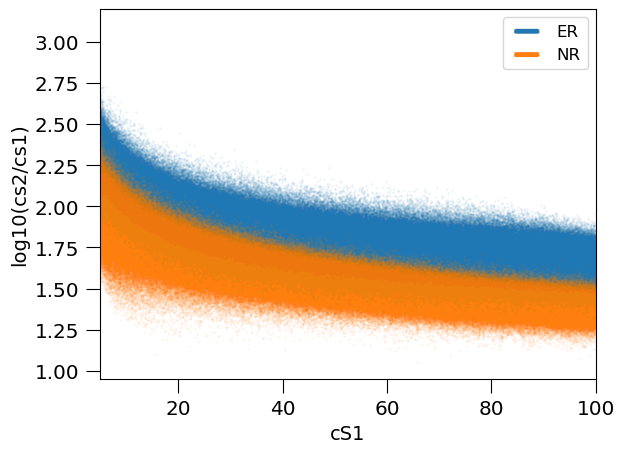

In [42]:
plt.scatter(s1_er, np.log10(s2_er/s1_er), label='ER', s=1, alpha=0.05)
plt.scatter(s1_nr, np.log10(s2_nr/s1_nr), label='NR',s=1,  alpha=0.05)
plt.legend(fontsize=12, scatterpoints=1000)
plt.xlabel('cS1', fontsize=14)
plt.ylabel('log10(cs2/cs1)', fontsize=14)
plt.xlim(5, 100)
plt.show()

In [43]:
s1_bins=np.linspace(1, 100, 100)
er_bins = np.digitize(s1_er, s1_bins)
nr_bins = np.digitize(s1_nr, s1_bins)

In [44]:
leakage_list = np.empty(s1_bins.shape[0])
for i, s1_bin in enumerate(s1_bins):
    er_in_bin = s2_er[er_bins==i]
    nr_in_bin = s2_nr[nr_bins==i]
    
    nr_median = np.median(nr_in_bin)
    leak_count = np.sum(er_in_bin<nr_median)
    leakage_fraction = leak_count/(er_in_bin.shape[0]+1e-9)
    
    leakage_list[i]=leakage_fraction

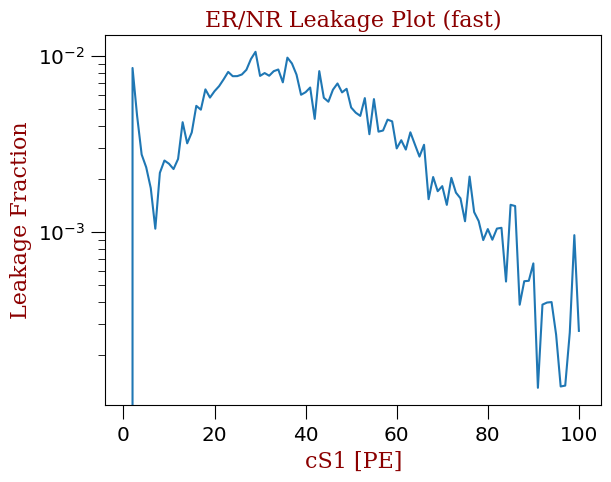

In [45]:
plt.plot(s1_bins, leakage_list, )
plt.yscale('log')
plt.xlabel('cS1 [PE]', fontdict=font_small)
plt.ylabel('Leakage Fraction', fontdict=font_small)
plt.title('ER/NR Leakage Plot (fast)', fontdict=font_small)
plt.show()

------